# Denoised and Pick DAS

This notebook test the ensemble deep learning picker from Yuan et al, 2023 on DAS data, whether it is raw data or denoised using MAE.

**Marine Denolle** and **Qibin Shi**

## To do:
1. manage memory
2. plot data before the pics
3. calculate SNR
4. polynomial regression and find outliers.
5. make plots with predicted and ignored data (light blue)
6. test entering DAS data as a horizontal channel.



Import modules


This notebook assumes that your environment has:
1. SeisBench
2. ELEP. Get it from there https://github.com/congcy/ELEP and install it

In [20]:
import sys
sys.path.append("../src/denoiser/")
sys.path.append("../src/ensemble_picker/")
sys.path.append("../models/")
import os
import gc
import h5py
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from matplotlib import pyplot as plt
from numpy.random import default_rng
from scipy.signal import filtfilt, butter
from torch.utils.data import DataLoader
from scipy.interpolate import interp1d

# This package
from das_denoise_models import unet, dataflow, datalabel
from das_denoise_training import train_augmentation
from das_util import try_gpu

# seisbench
import seisbench.models as sbm

# some ELEP functions
from mbf_elep_func import apply_elep



import os
devc = 0
os.environ['CUDA_VISIBLE_DEVICES'] = str(devc)

In [21]:
# from ELEP.elep.ensemble_statistics import ensemble_statistics
# from ELEP.elep.ensemble_coherence import ensemble_semblance 
# from ELEP.elep.ensemble_learners import ensemble_regressor_cnn
# from ELEP.elep import mbf, mbf_utils
# from ELEP.elep import trigger_func
# from ELEP.elep.trigger_func import picks_summary_simple


## Get the data

where is the data ?

In [22]:
! du -sh /fd1/QibinShi_data/akdas/qibin_data/*

100K	/fd1/QibinShi_data/akdas/qibin_data/ak_Oct_Nov.xml
18M	/fd1/QibinShi_data/akdas/qibin_data/event1.hdf5
18M	/fd1/QibinShi_data/akdas/qibin_data/event2.hdf5
18M	/fd1/QibinShi_data/akdas/qibin_data/event3.hdf5
18M	/fd1/QibinShi_data/akdas/qibin_data/event4.hdf5
18M	/fd1/QibinShi_data/akdas/qibin_data/event5.hdf5
18M	/fd1/QibinShi_data/akdas/qibin_data/event6.hdf5
18M	/fd1/QibinShi_data/akdas/qibin_data/event7.hdf5
18M	/fd1/QibinShi_data/akdas/qibin_data/event8.hdf5
18M	/fd1/QibinShi_data/akdas/qibin_data/event9.hdf5
8.3G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_07_22.hdf5
3.8G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_07_29.hdf5
5.2G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_08_12.hdf5
5.4G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_08_16.hdf5
11G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_08_18.hdf5
24G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_11_02.hdf5
24G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_11_11.hdf5
16G	/fd1/QibinShi

### Prepare and read Data

In [23]:
sampling_rate = 25 # number of points per second
dchan = 10 # channel spacing in mebers
chan_max = 6000  # maximum channel to trim the data

### Now we read data that was prepared as numpy arrays, combining 2 cables.

We need to recover the absolute start time of each of the files in order to assign ORIGIN TIME and TRAVEL TIME of our picks.

In [24]:
### Read (change the file to the latest if needed)
data_terra = '/fd1/QibinShi_data/akdas/qibin_data/TERRAtill2023_11_14.hdf5'
data_kkfls = '/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_11_14.hdf5'
with h5py.File(data_terra, 'r') as f:
    quake1 = f['raw_quake'][:,:chan_max,:]
with h5py.File(data_kkfls, 'r') as f:
    quake2 = f['raw_quake'][:,:chan_max,:]
    
# combine both arrays
rawdata =np.concatenate((quake2[:,::-1,:], quake1[:,:,:]),axis=1)

In [25]:
print(rawdata.shape)

(182, 12000, 1500)


In [26]:
print(rawdata.shape)
print(f'there are  {rawdata.shape[0]:d}  events, for {rawdata.shape[1]:d} channels, and {rawdata.shape[2]:d} samples in time')

(182, 12000, 1500)
there are  182  events, for 12000 channels, and 1500 samples in time


### Filter data & normalize

In [27]:
### Filter
b, a = butter(4, (0.5, 12), fs=sampling_rate, btype='bandpass')
filtered_data = filtfilt(b, a, rawdata, axis=2)


Plot the data .  Take the example of the 5th event

/tmp/ipykernel_524836/3655926224.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.figure(figsize=(12, 9)); cmap=plt.cm.get_cmap('RdBu')


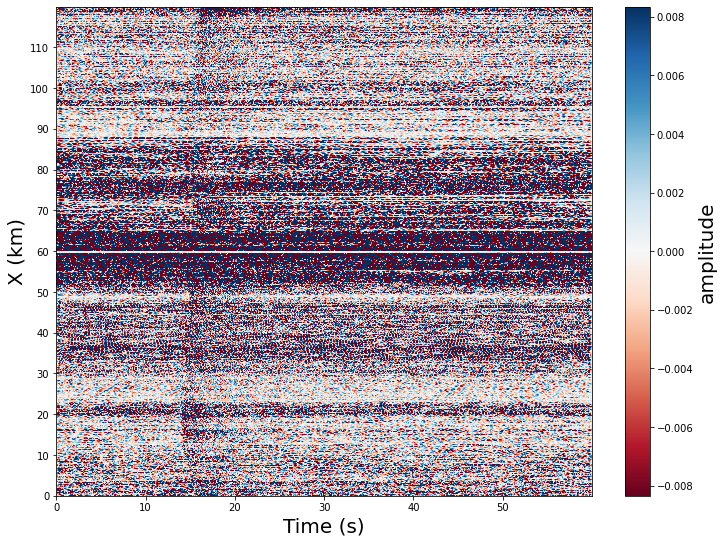

In [28]:
### visualize example data
time_data = filtered_data[5]
max_amp = np.median(np.fabs(time_data))*2
x, y=np.arange(time_data.shape[1]), np.arange(time_data.shape[0])

plt.figure(figsize=(12, 9)); cmap=plt.cm.get_cmap('RdBu')
plt.pcolormesh(x, y, time_data, shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
plt.xticks(np.arange(0, 1500, 250), np.arange(0, 1500/sampling_rate, 250/sampling_rate).astype(int))
plt.yticks(np.arange(0, 2*chan_max, 1000), (np.arange(0, 2*dchan*chan_max, 1000*dchan)/1000).astype(int))
plt.xlabel("Time (s)", fontsize=20); plt.ylabel("X (km)", fontsize=20)
cbr=plt.colorbar(); cbr.set_label('amplitude', fontsize = 20)

### Some useful functions for DAS processing

In [51]:
def process_3d_array(arr, len1=1500, len2=1500):
    """convert to numpy array"""
    arr = np.array(arr)
    
    """Ensure the array has at least len1 rows and len2 columns"""
    slices, rows, cols = arr.shape
    arr = arr[:, :min(rows, len1), :min(cols, len2)]
    
    """Pad zeros if it has fewer than len1 rows or len2 columns"""
    if rows < len1 or cols < len2:
        padding_rows = max(len1 - rows, 0)
        padding_cols = max(len2 - cols, 0)
        arr = np.pad(arr, ((0, 0), (0, padding_rows), (0, padding_cols)), 'constant')
    
    return arr


def Denoise_initMAE(data, weight_path, devc, device_id=[0,1,2,3], repeat=4, use_att=False):
    """ This function do the following (it does NOT filter data):
    1) load the denoiser
    2) call Denoise function
    """   
    """ Initialize the U-net model """
    model = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=use_att)
#     model = nn.DataParallel(model, device_ids=device_id)
    model = nn.DataParallel(model, device_ids=[devc])
    model.to(devc)
    model.load_state_dict(torch.load(weight_path))
    model.eval() 
    
    oneDenoise, mulDenoise = Denoise(data, model, devc)
    
    return oneDenoise, mulDenoise


def Denoise_largeDAS(data, model_func, devc, repeat=4, norm_batch=True):
    """ This function do the following (it does NOT filter data):
    1) split into multiple 1500-channel segments
    2) call Denoise function for each segments
    3) merge all segments
    
    data: 2D -- [channel, time]
    output: 2D, but padded 0 to have multiple of 1500 channels
    
    This code was primarily designed for the Alaska DAS, but applicable to other networks
    """ 
    nchan = len(data)
    ntime = len(data[0])
    
    if (nchan // 1500) == 0:
        n_seg = nchan // 1500
    else:
        n_seg = nchan // 1500 + 1
        
    full_len = n_seg * 1500
    
    pad_data = process_3d_array(data[np.newaxis,:,:], len1=full_len)
    data3d = pad_data.reshape((-1, 1500, 1500))
    del pad_data
    
#     oneDenoise, mulDenoise = Denoise(data3d, model_func, devc, repeat=repeat, norm_batch=norm_batch)
    oneDenoise = Denoise(data3d, model_func, devc, repeat=repeat, norm_batch=norm_batch)
    
    oneDenoise2d = oneDenoise.reshape((full_len, 1500))[:nchan, :ntime]
    del oneDenoise
#     mulDenoise2d = mulDenoise.reshape((full_len, 1500))[:nchan, :ntime]
    
    return oneDenoise2d #, mulDenoise2d
    

def Denoise(data, model_func, devc, repeat=4, norm_batch=False):
    """ This function do the following (it does NOT initialize model):

    1) normalized the data
    2) ensure the data format, precision and size
    3) denoise and scale back the output amplitude
    """ 
    
    """ convert to torch tensors """
    if norm_batch:
        scale = np.std(data[-1]) + 1e-7  ### Avoid potentially bad beginning channels
    else:
        scale = np.std(data, axis=(1,2), keepdims=True) + 1e-7
        
    data_norm = data / scale  ## standard scaling
    arr = process_3d_array(data_norm.astype(np.float32))
    X = torch.from_numpy(arr).to(devc)
    
    """ denoise - deploy """
    with torch.no_grad():
        oneDenoise = model_func(X)
#         mulDenoise = oneDenoise
        
#         for i in range(repeat-1):
#             mulDenoise = model_func(mulDenoise)

    """ convert back to numpy """
    oneDenoise = oneDenoise.to('cpu').numpy() * scale
#     mulDenoise = mulDenoise.to('cpu').numpy() * scale
    
    return oneDenoise[:, :len(data[0]), :len(data[0][0])]#, mulDenoise[:, :len(data[0]), :len(data[0][0])]
    
    
def vizRawDenoise(in_data, oneDenoise, mulDenoise, sample_rate=25, dchan=10, index=[0,1], model="MAE"):
    """
    in_data, oneDenoise, mulDenoise: 3D -- [event, channel, time]
    index: list, subset of the events
    model: string, descriptions about the model
    """
    len1, len2 = oneDenoise[0].shape[0], oneDenoise[0].shape[1]
    x, y = np.arange(len2), np.arange(len1)
    rawdata = process_3d_array(in_data, len1=len1, len2=len2)

    for j in index:
        bound = np.median(np.fabs(in_data[j]))*2
        fig, ax = plt.subplots(1, 2, figsize=(18, 6), constrained_layout=True)

        img=ax[0].pcolormesh(x, y, rawdata[j], shading='auto', vmin=-bound, vmax=bound, cmap=plt.cm.get_cmap('RdBu'))
        ax[1].pcolormesh(x, y, oneDenoise[j], shading='auto',  vmin=-bound, vmax=bound, cmap=plt.cm.get_cmap('RdBu'))
#         ax[2].pcolormesh(x, y, mulDenoise[j], shading='auto', vmin=-bound, vmax=bound, cmap=plt.cm.get_cmap('RdBu'))

        ax[0].set_title("Raw data #"+str(j), fontsize=24)
        ax[1].set_title(model+" 1-time denoised", fontsize=24)
#         ax[2].set_title(model+" multi-time denoised", fontsize=24)
        ax[0].set_ylabel('Distance (km)', fontsize=24)

        plt.colorbar(img, ax=ax[2])

        for i in range(3):
            ax[i].set_xlabel('Time (s)', fontsize=24)
            ax[i].set_xticks(np.arange(0, 250*(len2//250), 250)) 
            ax[i].set_xticklabels(np.arange(0, 250*(len2//250)/sample_rate, 250/sample_rate).astype(int))
            ax[i].set_yticks(np.arange(0, 200*(len1//200), 200))
            ax[i].set_yticklabels((np.arange(0, dchan*200*(len1//200), 200*dchan)/1000).astype(int))

### Prepare data to be denoised

Data smaller than 1500x1500 will be padded with 0. For deploying this denoiser, enter the entire image (not masked).

### Find models

In [30]:
""" what device to deploy the model """

""" what model to use """
# U-net trained on pure raw (scaled) data (input and output)
model_path_raw2raw='../models/checkpoint_noatt_LRdecays0.8_mask0.5_raw2raw.pt'
# U-net trained on raw input data and FK filtered output data
model_path_fk2fk  ='../models/checkpoint_noatt_LRdecays0.8_mask0.5_fk2fk.pt'
# U-net trained on raw data input and FK-filtered data ouput.
model_path_raw2fk ='../models/checkpoint_noatt_LRdecays0.8_mask0.5_raw2fk_taperTo_0.3.pt'

### Denoise strategy -- Initialize model and apply repeatedly

In [31]:
""" Initialize the U-net model """
model_raw2raw = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
# model_raw2raw = nn.DataParallel(model_raw2raw, device_ids=[0,1,2,3])
model_raw2raw = nn.DataParallel(model_raw2raw, device_ids=[devc])
model_raw2raw.to(devc)
model_raw2raw.load_state_dict(torch.load(model_path_raw2raw))
model_raw2raw.eval()

model_fk2fk = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
model_fk2fk = nn.DataParallel(model_fk2fk, device_ids=[devc])
# model_fk2fk = nn.DataParallel(model_fk2fk, device_ids=[0,1,2,3])
model_fk2fk.to(devc)
model_fk2fk.load_state_dict(torch.load(model_path_fk2fk))
model_fk2fk.eval()

model_raw2fk = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
model_raw2fk = nn.DataParallel(model_raw2fk, device_ids=[devc])
# model_raw2fk = nn.DataParallel(model_raw2fk, device_ids=[0,1,2,3])
model_raw2fk.to(devc)
model_raw2fk.load_state_dict(torch.load(model_path_raw2fk))
model_raw2fk.eval()

DataParallel(
  (module): unet(
    (relu): ReLU()
    (layer): ModuleList(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): MaxBlurPool2d()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): MaxBlurPool2d()
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): MaxBlurPool2d()
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): Dropout(p=0.2, inplace=False)
      (12): MaxBlurPool2d()
      (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1

## Apply denoiser on the entire data set

In [32]:
""" apply the denoisers """
mulDenoise_1=np.zeros(shape=(filtered_data.shape))
oneDenoise_1=np.zeros(shape=(filtered_data.shape))
for ievt in range(filtered_data.shape[0]):
    oneDenoise_1[ievt,:,:], mulDenoise_1[ievt,:,:] = Denoise_largeDAS(filtered_data[ievt,:,:], model_raw2raw, devc, norm_batch=True)
    print(ievt/filtered_data.shape[0])

0.0
0.005494505494505495
0.01098901098901099
0.016483516483516484
0.02197802197802198
0.027472527472527472
0.03296703296703297
0.038461538461538464
0.04395604395604396
0.04945054945054945
0.054945054945054944
0.06043956043956044
0.06593406593406594
0.07142857142857142
0.07692307692307693
0.08241758241758242
0.08791208791208792
0.09340659340659341
0.0989010989010989
0.1043956043956044
0.10989010989010989
0.11538461538461539
0.12087912087912088
0.12637362637362637
0.13186813186813187
0.13736263736263737
0.14285714285714285
0.14835164835164835
0.15384615384615385
0.15934065934065933
0.16483516483516483
0.17032967032967034
0.17582417582417584
0.1813186813186813
0.18681318681318682
0.19230769230769232
0.1978021978021978
0.2032967032967033
0.2087912087912088
0.21428571428571427
0.21978021978021978
0.22527472527472528
0.23076923076923078
0.23626373626373626
0.24175824175824176
0.24725274725274726
0.25274725274725274
0.25824175824175827
0.26373626373626374
0.2692307692307692
0.2747252747252747

### Visualized the raw and denoised DAS

/tmp/ipykernel_524836/551988203.py:115: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  img=ax[0].pcolormesh(x, y, rawdata[j], shading='auto', vmin=-bound, vmax=bound, cmap=plt.cm.get_cmap('RdBu'))
/tmp/ipykernel_524836/551988203.py:116: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax[1].pcolormesh(x, y, oneDenoise[j], shading='auto',  vmin=-bound, vmax=bound, cmap=plt.cm.get_cmap('RdBu'))
/tmp/ipykernel_524836/551988203.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax[

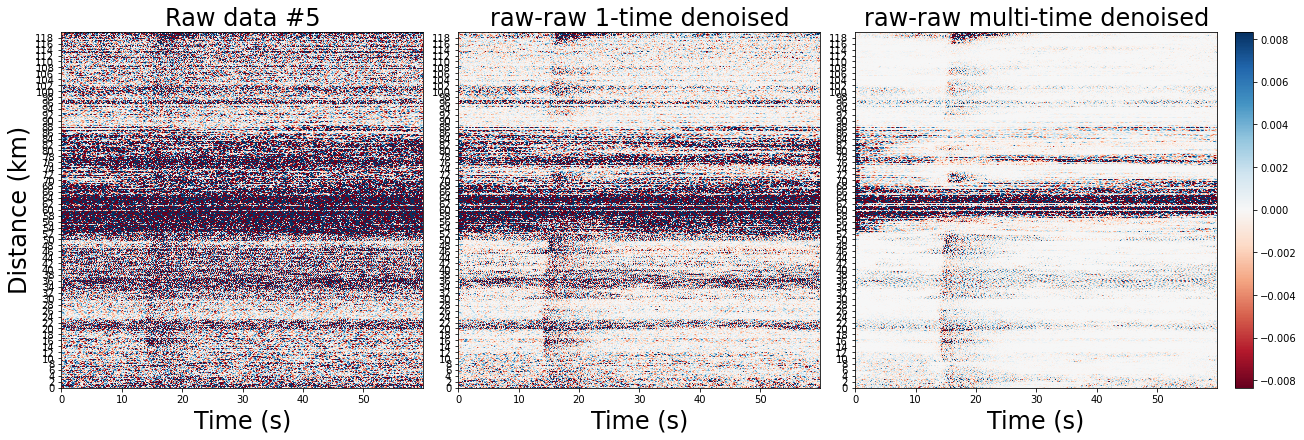

In [33]:
""" select images using the index list """
vizRawDenoise(filtered_data, oneDenoise_1, mulDenoise_1, index=[5], model="raw-raw")
# vizRawDenoise(filtered_data, oneDenoise_2, mulDenoise_2, index=[5], model="fk-fk")
# vizRawDenoise(filtered_data, oneDenoise_3, mulDenoise_3, index=[5], model="raw-fk")

## Time to pick!

In [34]:
# ML picker parameters
paras_semblance = {'dt':0.025, 'semblance_order':4, 'window_flag':True, 
                   'semblance_win':0.5, 'weight_flag':'max'}
p_thrd, s_thrd = 0.01, 0.05
fqmin = 0.1
fqmax = 5

dt = 0.001; fs = 100
nfqs = 10
nt = 6000; nc = 3
fq_list = [1]#make_LogFq(fqmin, fqmax, dt, nfqs)
coeff_HP, coeff_LP = [1,1]#rec_filter_coeff(fq_list, dt)
MBF_paras = {'f_min':fqmin, 'f_max':fqmax, 'nfqs':nfqs, 'frequencies':fq_list, 'CN_HP':coeff_HP, 'CN_LP':coeff_LP, \
    'dt':dt, 'fs':fs, 'nt':nt, 'nc':nc, 'npoles': 2}

In [35]:
# download models
pretrain_list = ["ethz","instance","scedc","stead","geofon","neic"]
# pn_pnw_model = sbm.EQTransformer.from_pretrained('pnw')
pn_ethz_model = sbm.EQTransformer.from_pretrained("ethz")
pn_instance_model = sbm.EQTransformer.from_pretrained("instance")
pn_scedc_model = sbm.EQTransformer.from_pretrained("scedc")
pn_stead_model = sbm.EQTransformer.from_pretrained("stead")
pn_geofon_model = sbm.EQTransformer.from_pretrained("geofon")
pn_neic_model = sbm.EQTransformer.from_pretrained("neic")

list_models = [pn_ethz_model,pn_scedc_model,pn_neic_model,pn_geofon_model,pn_stead_model,pn_instance_model]

In [36]:
pn_ethz_model.to(devc);
pn_scedc_model.to(devc);
pn_neic_model.to(devc);
pn_geofon_model.to(devc);
pn_stead_model.to(devc);
pn_instance_model.to(devc);

Resample the data to 100Hz.

We will consider the first 100 events with Nevent.

In [37]:
Nevent=100

In [38]:
mulDenoise_1.shape

(182, 12000, 1500)

The denoised is the full image on both cables. 12000 channels, 1500 time stamps, ~ 182 earthquakes. LOTS OF DATA.
It has to be interpolated in order to be sent to the phase picker.

In [39]:
# interpolate the denoised data.
# interpolation_function = interp1d(np.linspace(0, 1, 1500), mulDenoise_1[:,:,:], axis=2, kind='linear')
# interpolated_denoised = interpolation_function(np.linspace(0, 1, 6000))

In [40]:
# check that the dimension of the interpolated waveform data is the same.
# print(interpolated_image.shape)
# print(interpolated_denoised.shape)

## Apply Phase Picking

apply ELEP MBF picking below as a loop over events.

Select max number of channels with Nchanmax during debugging.

Plot the picks and save the plots.


Todo:
* Assign start time of each event data and save into dataframe
* store picks in data frame
* Assign good quality picks from low quality picks to disregard picks

 REWRITE to make 1 loop
1) denoise per event

2) for each channel - interpolate - phase pick

3) make a polynomial fit in phase picks, remove outliers.


In [41]:
# crap=np.zeros((interpolated_image.shape[0],interpolated_image.shape[1]))
# Nchanmax=6000
# Nevent=100
# nzeros_p = np.zeros(Nevent,dtype=np.int32)
# mean_p = np.zeros(Nevent)
# std_p = np.zeros(Nevent)
# nzeros_s = np.zeros(Nevent,dtype=np.int32)
# mean_s = np.zeros(Nevent)
# std_s = np.zeros(Nevent)

# nzeros_p_denoised = np.zeros(Nevent)
# mean_p_denoised  = np.zeros(Nevent)
# std_p_denoised  = np.zeros(Nevent)
# nzeros_s_denoised  = np.zeros(Nevent)
# mean_s_denoised  = np.zeros(Nevent)
# std_s_denoised  = np.zeros(Nevent)
# for i in range(1,20):#interpolated_image.shape[0]):

#     pick=  apply_elep(interpolated_image[i,:Nchanmax,:], list_models, MBF_paras, paras_semblance,thr=0.01,device=devc)       
#     max_amp = np.median(np.fabs(interpolated_image[i,:Nchanmax,:]))*2
#     x, y = np.arange(interpolated_image[i,:Nchanmax,:].shape[1]), np.arange(interpolated_image[i,:Nchanmax,:].shape[0])
# #     pick=  apply_elep(interpolated_image[i,:Nchanmax,:], list_models, MBF_paras, paras_semblance,thr=0.01,device=devc)       
# #     max_amp = np.median(np.fabs(interpolated_image[i,:Nchanmax,:]))*2
# #     x, y = np.arange(interpolated_image[i,:Nchanmax,:].shape[1]), np.arange(interpolated_image[i,:Nchanmax,:].shape[0])
#     plt.figure()
#     plt.pcolormesh(x/fs, y*dchan/1000,interpolated_image[i,:Nchanmax,:],\
#                    shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap,\
#                   alpha=0.7)
# #     plt.pcolormesh(x/fs, y*dchan/1000,interpolated_image[i,:Nchanmax,:],\
# #                    shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap,\
# #                   alpha=0.7)
#     plt.xlabel("Time since starttime (s)")
#     plt.ylabel("Distance along cable (km)")
#     plt.yticks(np.arange(0, Nchanmax, Nchanmax/5), np.arange(0, Nchanmax, Nchanmax/5)*dchan/1000)
#     plt.scatter(pick[:,0],y*dchan/1000,s=12,marker='o',c="b")
#     plt.scatter(pick[:,1],y*dchan/1000,s=12,marker='o',c="r")
#     plt.title("Ensemble Picking on Raw data")
#     plt.savefig(f"./raw_ELEP_bb_picks_event_{i}.png")
#     plt.show()
    
#     # get statistical measures of these picks.
#     # first only look at non zeros
#     nzeros_p[i] = len(pick[pick[:,0]==0,0])
#     mean_p[i] = np.mean(pick[pick[:,0]!=0,0])
#     std_p[i] = np.std(pick[pick[:,0]!=0,0])
#     nzeros_s[i] = len(pick[pick[:,1]==0,1])
#     mean_s[i] = np.mean(pick[pick[:,1]!=0,1])
#     std_s[i] = np.std(pick[pick[:,1]!=0,1])
    
    
#     colors = ['blue', 'red']
#     labels = ['P BB', 'S BB']
#     plt.figure()
#     plt.hist(pick[:,0],bins=10,alpha=0.5,color=colors[0],label=labels[0],range=(0,60))
#     plt.hist(pick[:,1],bins=10,alpha=0.5,color=colors[1],label=labels[1],range=(0,60))
# #     plt.title(f"Picks histograms std P {%d}",(mean_p_p))
#     plt.legend(labels)
#     plt.xlabel("Time since starttime (s)")
#     plt.savefig(f"./hist_raw_ELEP_bb_picks_event_{i}.png")
#     plt.show()
    
   
#     pickd=  apply_elep(interpolated_denoised[i,:Nchanmax,:], list_models, MBF_paras, paras_semblance,thr=0.01,device=devc)       
#     max_amp = np.median(np.fabs(interpolated_denoised[i,:Nchanmax,:]))*2
#     x, y = np.arange(interpolated_denoised[i,:Nchanmax,:].shape[1]), np.arange(interpolated_denoised[i,:Nchanmax,:].shape[0])
    

# #     pick=  apply_elep(interpolated_denoised[i,:Nchanmax,:], list_models, MBF_paras, paras_semblance,thr=0.01,device=devc)       
# #     max_amp = np.median(np.fabs(interpolated_denoised[i,:Nchanmax,:]))*2
# #     x, y = np.arange(interpolated_denoised[i,:Nchanmax,:].shape[1]), np.arange(interpolated_denoised[i,:Nchanmax,:].shape[0])
    
#     plt.figure()
#     plt.pcolormesh(x/fs, y*dchan/1000,interpolated_denoised[i,:Nchanmax,:], \
#                    shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap,\
#                   alpha=0.7)
# #     plt.pcolormesh(x/fs, y*dchan/1000,interpolated_denoised[i,:Nchanmax,:], \
# #                    shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap,\
# #                   alpha=0.7)
#     plt.xlabel('Time since starttime (s)')
#     plt.ylabel("Distance along cable (km)")
#     plt.yticks(np.arange(0, Nchanmax, Nchanmax/5), np.arange(0, Nchanmax, Nchanmax/5)*dchan/1000)
#     plt.scatter(pickd[:,0],y*dchan/1000,s=12,marker='o',c="b")
#     plt.scatter(pickd[:,1],y*dchan/1000,s=12,marker='o',c="r")
#     plt.title("Ensemble Picking on Denoised data")
#     plt.savefig(f"./denoised_ELEP_bb_picks_event_{i}.png")
#     plt.show()
    
    
#     nzeros_p_denoised[i] = len(pick[pickd[:,0]==0,0])
#     mean_p_denoised[i] = np.mean(pickd[pickd[:,0]!=0,0])
#     std_p_denoised[i] = np.std(pickd[pickd[:,0]!=0,0])
#     nzeros_s_denoised[i] = len(pickd[pickd[:,1]==0,1])
#     mean_s_denoised[i] = np.mean(pickd[pickd[:,1]!=0,1])
#     std_s_denoised[i] = np.std(pickd[pickd[:,1]!=0,1])
    
    
    
#     plt.hist(pickd[:,0],bins=10,alpha=0.5,color=colors[0],label=labels[0],range=(0,60))
#     plt.hist(pickd[:,1],bins=10,alpha=0.5,color=colors[1],label=labels[1],range=(0,60))
#     plt.title("Picks histograms")
#     plt.xlabel("Time since starttime (s)")
#     plt.legend(labels)
#     plt.savefig(f"./hist_denoised_ELEP_bb_picks_event_{i}.png")
#     plt.show()
    
#     print("Number of zeros picked in P {} {} (raw+denoised) and S {} {} (raw+denoised)".format(
#           nzeros_p[i] ,nzeros_p_denoised[i] ,nzeros_s[i] ,nzeros_s_denoised[i] ))
#     print("Mean picked in P {:.2f} {:.2f} (raw+denoised) and S {:.2f} {:.2f} (raw+denoised) ".format(
#           mean_p[i] ,mean_p_denoised[i] ,mean_s[i] ,mean_s_denoised[i] ))
#     print("Standard deviation in P {:.2f} {:.2f} (raw+denoised) and S {:.2f} {:.2f} (raw+denoised)".format(
#           std_p[i] ,std_p_denoised[i] ,std_p_denoised[i] ,std_s_denoised[i] ))
    

    
#     pdict = {'Event_ID':i*np.ones(len(pick[:,1])),'channel_ID':np.arange(0,len(pick[:,1])),\
#              'P_picks_raw':pick[:,0],'S_picks_raw':pick[:,1],\
#              'P_picks_denoised':pickd[:,0],'S_picks_denoised':pickd[:,1]}
    
    
    
#     ddict = {'nzeros_p':nzeros_p[:i],'nzeros_s':nzeros_s[:i],\
#              'nzeros_p_denoised':nzeros_p_denoised[:i],'nzeros_s_denoised':nzeros_s_denoised[:i],\
#             'mean_p':mean_p[:i],'nzeros_s':mean_s[:i],\
#              'mean_p_denoised':mean_p_denoised[:i],'mean_s_denoised':mean_s_denoised[:i],\
#             'std_p':std_p[:i],'std_s':std_s[:i],\
#              'std_p_denoised':std_p_denoised[:i],'std_s_denoised':std_s_denoised[:i]}
    
#     df=pd.DataFrame.from_dict(ddict)
#     df.to_csv("performance_metrics_denoising_picking.csv")
#     dfp=pd.DataFrame.from_dict(pdict)
#     dfp.to_csv("elep_picks.csv")
#     print(" ")
#     print(" ")
#     print(" ")


In [45]:
Nchanmax=6000
Nevent=100
nzeros_p = np.zeros(Nevent,dtype=np.int32)
mean_p = np.zeros(Nevent)
std_p = np.zeros(Nevent)
nzeros_s = np.zeros(Nevent,dtype=np.int32)
mean_s = np.zeros(Nevent)
std_s = np.zeros(Nevent)

nzeros_p_denoised = np.zeros(Nevent)
mean_p_denoised  = np.zeros(Nevent)
std_p_denoised  = np.zeros(Nevent)
nzeros_s_denoised  = np.zeros(Nevent)
mean_s_denoised  = np.zeros(Nevent)
std_s_denoised  = np.zeros(Nevent)
snr_raw = np.zeros(shape=(Nevent,2*Nchanmax))
snr_denoised = np.zeros(shape=(Nevent,2*Nchanmax))



for i in range(1,20):#interpolated_image.shape[0]):
    
    print(filtered_data[i,:,:].shape)
    # interpolate the raw data
    interpolation_function = interp1d(np.linspace(0, 1, 1500), filtered_data[i,:,:], axis=1, kind='linear')
    print(interpolation_function)
    interpolated_image = interpolation_function(np.linspace(0, 1, 6000))
    # interpolate the denoised data
    interpolation_function = interp1d(np.linspace(0, 1, 1500), mulDenoise_1[i,:,:], axis=1, kind='linear')
    interpolated_denoised = interpolation_function(np.linspace(0, 1, 6000))
    
    print("interpolated ")
    # pick
    pick=  apply_elep(interpolated_image, list_models, MBF_paras, paras_semblance,thr=0.01,device=devc)   
    
    print("picked! ")
    
    # plot
    max_amp = np.median(np.fabs(interpolated_image))*2
    x, y = np.arange(interpolated_image.shape[1]), np.arange(interpolated_image.shape[0])
#     pick=  apply_elep(interpolated_image[i,:Nchanmax,:], list_models, MBF_paras, paras_semblance,thr=0.01,device=devc)       
#     max_amp = np.median(np.fabs(interpolated_image[i,:Nchanmax,:]))*2
#     x, y = np.arange(interpolated_image[i,:Nchanmax,:].shape[1]), np.arange(interpolated_image[i,:Nchanmax,:].shape[0])
    plt.figure()
    plt.pcolormesh(x/fs, y*dchan/1000,interpolated_image,\
                   shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap,\
                  alpha=0.7)
#     plt.pcolormesh(x/fs, y*dchan/1000,interpolated_image[i,:Nchanmax,:],\
#                    shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap,\
#                   alpha=0.7)
    plt.xlabel("Time since starttime (s)")
    plt.ylabel("Distance along cable (km)")
    plt.yticks(np.arange(0, 2*Nchanmax, Nchanmax/5), np.arange(0, 2*Nchanmax, Nchanmax/5)*dchan/1000)
    plt.scatter(pick[:,0],y*dchan/1000,s=12,marker='o',c="b")
    plt.scatter(pick[:,1],y*dchan/1000,s=12,marker='o',c="r")
    plt.title("Ensemble Picking on Raw data")
    plt.savefig(f"./plots/raw_ELEP_bb_picks_event_{i}.png")
    plt.show()
    
    # get statistical measures of these picks.
    # first only look at non zeros
    nzeros_p[i] = len(pick[pick[:,0]==0,0])
    mean_p[i] = np.mean(pick[pick[:,0]!=0,0])
    std_p[i] = np.std(pick[pick[:,0]!=0,0])
    nzeros_s[i] = len(pick[pick[:,1]==0,1])
    mean_s[i] = np.mean(pick[pick[:,1]!=0,1])
    std_s[i] = np.std(pick[pick[:,1]!=0,1])
    
    
    colors = ['blue', 'red']
    labels = ['P BB', 'S BB']
    plt.figure()
    plt.hist(pick[:,0],bins=10,alpha=0.5,color=colors[0],label=labels[0],range=(0,60))
    plt.hist(pick[:,1],bins=10,alpha=0.5,color=colors[1],label=labels[1],range=(0,60))
#     plt.title(f"Picks histograms std P {%d}",(mean_p_p))
    plt.legend(labels)
    plt.xlabel("Time since starttime (s)")
    plt.savefig(f"./plots/hist_raw_ELEP_bb_picks_event_{i}.png")
    plt.show()
    
   
    pickd=  apply_elep(interpolated_denoised, list_models, MBF_paras, paras_semblance,thr=0.01,device=devc)       
    max_amp = np.median(np.fabs(interpolated_denoised))*2
    x, y = np.arange(interpolated_denoised.shape[1]), np.arange(interpolated_denoised.shape[0])

#     pick=  apply_elep(interpolated_denoised[i,:Nchanmax,:], list_models, MBF_paras, paras_semblance,thr=0.01,device=devc)       
#     max_amp = np.median(np.fabs(interpolated_denoised[i,:Nchanmax,:]))*2
#     x, y = np.arange(interpolated_denoised[i,:Nchanmax,:].shape[1]), np.arange(interpolated_denoised[i,:Nchanmax,:].shape[0])
    
    plt.figure()
    plt.pcolormesh(x/fs, y*dchan/1000,interpolated_denoised, \
                   shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap,\
                  alpha=0.7)
#     plt.pcolormesh(x/fs, y*dchan/1000,interpolated_denoised[i,:Nchanmax,:], \
#                    shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap,\
#                   alpha=0.7)
    plt.xlabel('Time since starttime (s)')
    plt.ylabel("Distance along cable (km)")
    plt.yticks(np.arange(0, 2*Nchanmax, Nchanmax/5), np.arange(0, 2*Nchanmax, Nchanmax/5)*dchan/1000)
    plt.scatter(pickd[:,0],y*dchan/1000,s=12,marker='o',c="b")
    plt.scatter(pickd[:,1],y*dchan/1000,s=12,marker='o',c="r")
    plt.title("Ensemble Picking on Denoised data")
    plt.savefig(f"./plots/denoised_ELEP_bb_picks_event_{i}.png")
    plt.show()
    
    
    nzeros_p_denoised[i] = len(pick[pickd[:,0]==0,0])
    mean_p_denoised[i] = np.mean(pickd[pickd[:,0]!=0,0])
    std_p_denoised[i] = np.std(pickd[pickd[:,0]!=0,0])
    nzeros_s_denoised[i] = len(pickd[pickd[:,1]==0,1])
    mean_s_denoised[i] = np.mean(pickd[pickd[:,1]!=0,1])
    std_s_denoised[i] = np.std(pickd[pickd[:,1]!=0,1])
    
    
    
    plt.hist(pickd[:,0],bins=10,alpha=0.5,color=colors[0],label=labels[0],range=(0,60))
    plt.hist(pickd[:,1],bins=10,alpha=0.5,color=colors[1],label=labels[1],range=(0,60))
    plt.title("Picks histograms")
    plt.xlabel("Time since starttime (s)")
    plt.legend(labels)
    plt.savefig(f"./plots/hist_denoised_ELEP_bb_picks_event_{i}.png")
    plt.show()
    
    
    # calculate SNR
    
    # calculate noise level
    ip = int(pick[pick[0,:]>0,0]*100)
    ipd = int(pick[pickd[0,:]>0,0]*100)
    snr_raw[i,:]=np.max(np.abs(interpolated_image[ip:ip+500*np.ones(len(ip))]),axis=1)/np.std(interpolated_image[:ip],axis=1)
    snr_denoise[i,:]=np.max(np.abs(interpolated_denoised[ipd:ipd+500*np.ones(len(ipd))]),axis=1)/np.std(interpolated_denoised[:ipd],axis=1)
    
    
    
    print("Number of zeros picked in P {} {} (raw+denoised) and S {} {} (raw+denoised)".format(
          nzeros_p[i] ,nzeros_p_denoised[i] ,nzeros_s[i] ,nzeros_s_denoised[i] ))
    print("Mean picked in P {:.2f} {:.2f} (raw+denoised) and S {:.2f} {:.2f} (raw+denoised) ".format(
          mean_p[i] ,mean_p_denoised[i] ,mean_s[i] ,mean_s_denoised[i] ))
    print("Standard deviation in P {:.2f} {:.2f} (raw+denoised) and S {:.2f} {:.2f} (raw+denoised)".format(
          std_p[i] ,std_p_denoised[i] ,std_p_denoised[i] ,std_s_denoised[i] ))
    print("SNR raw {:.2f} SNR denoised {:.2f} ".format(
          np.mean(snr_raw[i,:]) ,np.mean(snr_denoise[i,:]) ))
    

    
    pdict = {'Event_ID':i*np.ones(len(pick[:,1])),'channel_ID':np.arange(0,len(pick[:,1])),\
             'P_picks_raw':pick[:,0],'S_picks_raw':pick[:,1],\
             'P_picks_denoised':pickd[:,0],'S_picks_denoised':pickd[:,1]}
    
    
    
    ddict = {'nzeros_p':nzeros_p[:i],'nzeros_s':nzeros_s[:i],\
             'nzeros_p_denoised':nzeros_p_denoised[:i],'nzeros_s_denoised':nzeros_s_denoised[:i],\
            'mean_p':mean_p[:i],'nzeros_s':mean_s[:i],\
             'mean_p_denoised':mean_p_denoised[:i],'mean_s_denoised':mean_s_denoised[:i],\
            'std_p':std_p[:i],'std_s':std_s[:i],\
             'std_p_denoised':std_p_denoised[:i],'std_s_denoised':std_s_denoised[:i]}
    
    df=pd.DataFrame.from_dict(ddict)
    df.to_csv("./plots/performance_metrics_denoising_picking.csv")
    dfp=pd.DataFrame.from_dict(pdict)
    dfp.to_csv("./results/elep_picks.csv")
    print(" ")
    print(" ")
    print(" ")


(12000, 1500)
interpolated 


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.15 GiB (GPU 0; 79.15 GiB total capacity; 71.74 GiB already allocated; 464.62 MiB free; 75.24 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF